In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [9]:
from __future__ import division

import numpy as np
import glob, time, pickle, os, json
import matplotlib.pyplot as plt
import scipy.sparse as sps
import scipy.linalg as sl
from scipy.stats import chi2

import enterprise
from enterprise.pulsar import Pulsar
from enterprise.signals import parameter
from enterprise.signals import white_signals
from enterprise.signals import utils
from enterprise.signals import gp_signals
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection

import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

In [10]:
#Directories for MDC2
dataset = '/dataset_1b'

fstat_dir = os.getcwd()
mdc2_dir = os.path.split(fstat_dir)[0]
#Where the original data is
origdatadir = mdc2_dir + '/MDC2/mdc2/group1' + dataset
#Where the json noise file is
noisefile = mdc2_dir + '/MDC2/mdc2/group1/challenge1_psr_noise.json'
#Where the everything should be saved to (chains, cornerplts, histograms, etc.
savedir = fstat_dir
#The pickled pulsars
psr_obj_file = fstat_dir + '/mdc2_psr_objects.pickle'

In [11]:
#par and tim from mdc2
parfiles = sorted(glob.glob(origdatadir + '/*.par'))
timfiles = sorted(glob.glob(origdatadir + '/*.tim'))

In [12]:
#Loading par and tim files into enterprise Pulsar class
#Load all the pulsars if no pickle file
try:
    #Load pulsars from pickle file
    with open(psr_obj_file,'rb') as psrfile:
        psrs_mdc2 = pickle.load(psrfile)
        psrfile.close()
except:
    #If no pickle file, load and save pulsars
    psrs_mdc2 = []
    for p, t in zip(parfiles,timfiles):
        psr = Pulsar(p, t)
        psrs_mdc2.append(psr)
    #Save pulsars to a pickle file
    with open(psr_obj_file,'wb') as psrfile:
        pickle.dump(psrs_mdc2,psrfile)
        psrfile.close()

In [13]:
#Get true noise values for pulsars in mdc2
params_mdc2 = {}
with open(noisefile, 'r') as nf:
    params_dict_mdc2 = json.load(nf)
    nf.close()
for psr, params in params_dict_mdc2.items():
    for param_name, param_val in params.items():
        if param_name == 'efac':
            updated_param_name = psr + '_efac'
        elif param_name == 'equad':
            updated_param_name = psr + '_log10_equad'
        elif param_name == 'ecorr':
            updated_param_name = psr + '_log10_ecorr'
        elif param_name == 'rn_log10_A':
            updated_param_name = psr + '_red_noise_log10_A'
        elif param_name == 'rn_spec_ind':
            updated_param_name = psr + '_red_noise_gamma'

        params_mdc2[updated_param_name] = param_val

In [14]:
def GetTspan(psrs):
    tmin = [p.toas.min() for p in psrs]
    tmax = [p.toas.max() for p in psrs]
    Tspan = np.max(tmax) - np.min(tmin)
    return Tspan

In [15]:
##### parameters and priors for MDC2 #####
Tspan_mdc2 = GetTspan(psrs_mdc2)

# white noise parameters
efac = parameter.Constant()
log10_equad = parameter.Constant()
ecorr = parameter.Constant()

# red noise parameters
log10_A = parameter.Constant()
gamma = parameter.Constant()

'''
# GW parameters (initialize with names here to use parameters in common across pulsars)
log10_A_gw = parameter.LinearExp(-18,-12)('log10_A_gw')
gamma_gw = parameter.Constant(4.33)('gamma_gw')
'''

# red noise (powerlaw with 30 frequencies)
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)

rn_mdc2 = gp_signals.FourierBasisGP(spectrum=pl, Tspan=Tspan_mdc2)

'''
# gwb (no spatial correlations)
cpl = utils.powerlaw(log10_A=log10_A_gw, gamma=gamma_gw)
gw = gp_signals.FourierBasisGP(spectrum=cpl, components=30, Tspan=Tspan)
'''

# timing model
tm = gp_signals.TimingModel()

##### Set up signals #####

# white noise
ef = white_signals.MeasurementNoise(efac=efac)
eq = white_signals.EquadNoise(log10_equad=log10_equad)

# full model is sum of components
model_mdc2 = tm + ef + eq + rn_mdc2

# intialize PTA
pta_mdc2 = signal_base.PTA([model_mdc2(psr) for psr in psrs_mdc2])

In [16]:
#Set Default PTA parameters to the ones in the noisefiles
pta_mdc2.set_default_params(params_mdc2)

INFO: enterprise.signals.signal_base: Setting J0030+0451_efac to 1.1327054973277817
INFO: enterprise.signals.signal_base: Setting J0030+0451_log10_equad to -6.734253117324852
INFO: enterprise.signals.signal_base: Setting J0030+0451_red_noise_log10_A to -14.148297681223301
INFO: enterprise.signals.signal_base: Setting J0030+0451_red_noise_gamma to 4.495492402026417
INFO: enterprise.signals.signal_base: Setting J0034-0534_efac to 1.2598373277400674
INFO: enterprise.signals.signal_base: Setting J0034-0534_log10_equad to -6.641425922580685
INFO: enterprise.signals.signal_base: Setting J0034-0534_red_noise_log10_A to -16.538151630942075
INFO: enterprise.signals.signal_base: Setting J0034-0534_red_noise_gamma to 3.34288428623134
INFO: enterprise.signals.signal_base: Setting J0218+4232_efac to 1.3501857107640765
INFO: enterprise.signals.signal_base: Setting J0218+4232_log10_equad to -6.753752501179396
INFO: enterprise.signals.signal_base: Setting J0218+4232_red_noise_log10_A to -16.7050885818

INFO: enterprise.signals.signal_base: Setting J1857+0943_red_noise_log10_A to -14.240807998662445
INFO: enterprise.signals.signal_base: Setting J1857+0943_red_noise_gamma to 4.6295408167717005
INFO: enterprise.signals.signal_base: Setting J1909-3744_efac to 1.095400467856472
INFO: enterprise.signals.signal_base: Setting J1909-3744_log10_equad to -7.213183522763408
INFO: enterprise.signals.signal_base: Setting J1909-3744_red_noise_log10_A to -17.32727924372078
INFO: enterprise.signals.signal_base: Setting J1909-3744_red_noise_gamma to 3.18721293346236
INFO: enterprise.signals.signal_base: Setting J1918-0642_efac to 1.0819378030429965
INFO: enterprise.signals.signal_base: Setting J1918-0642_log10_equad to -7.556289609789052
INFO: enterprise.signals.signal_base: Setting J1918-0642_red_noise_log10_A to -15.681503899653743
INFO: enterprise.signals.signal_base: Setting J1918-0642_red_noise_gamma to 3.161506983264447
INFO: enterprise.signals.signal_base: Setting J1939+2134_efac to 2.205813948

In [17]:
# make sure all pulsar have same reference time
def GetRefTime(psrs):
    tt=[] 
    for p in psrs:
        tt.append(np.min(p.toas))

    # find reference time
    tref = np.min(tt)
    newtoas = []
    # now scale pulsar time
    for p in psrs:
        newtoas.append((p.toas - tref))
    return newtoas

In [18]:
def GenNmat(pta,params):
    '''Makes the Nmatrix used in the fstatistic'''
    TNTs = pta.get_TNT(params)
    phiinvs = pta.get_phiinv(params, logdet=False, method='partition') 
    #Get noise parameters for pta toaerr**2
    Nvecs = pta.get_ndiag(params)
    #Get the basis matrix
    Ts = pta.get_basis(params)
    Nmat = []
    print('Making Nmat')
    l1 = np.shape(TNTs)[0]
    i = 1
    
    for phiinv, TNT, Nvec, T in zip(phiinvs, TNTs, Nvecs, Ts):
        start = time.time()
        Sigma = TNT + (np.diag(phiinv) if phiinv.ndim == 1 else phiinv)
        cf = sl.cho_factor(Sigma)      
        Nshape = np.shape(T)[0]
        TtN = Nvec.solve(other = np.eye(Nshape),left_array = T)
        
        #Put pulsar's autoerrors in a diagonal matrix
        Ndiag = Nvec.solve(other = np.eye(Nshape),left_array = np.eye(Nshape))
    
        expval2 = sl.cho_solve(cf,TtN)
        #TtNt = np.transpose(TtN)
        
        #An Ntoa by Ntoa noise matrix to be used in expand dense matrix calculations earlier
        Nmat.append(Ndiag - np.dot(TtN.T,expval2))
        end = time.time()
        print(repr(i) + ' out of ' + repr(l1) + ' Done. Time: ' + repr(end-start))
        i += 1
    return Nmat

In [19]:
#Making Nmatrix for mdc2
Nmat_mdc2 = GenNmat(pta_mdc2,params_mdc2)

Making Nmat
1 out of 33 Done. Time: 0.09025907516479492
2 out of 33 Done. Time: 0.001367807388305664
3 out of 33 Done. Time: 0.0007126331329345703
4 out of 33 Done. Time: 0.0007472038269042969
5 out of 33 Done. Time: 0.0007016658782958984
6 out of 33 Done. Time: 0.0006775856018066406
7 out of 33 Done. Time: 0.0006558895111083984
8 out of 33 Done. Time: 0.0009524822235107422
9 out of 33 Done. Time: 0.0009708404541015625
10 out of 33 Done. Time: 0.0010759830474853516
11 out of 33 Done. Time: 0.0012078285217285156
12 out of 33 Done. Time: 0.000989675521850586
13 out of 33 Done. Time: 0.0010027885437011719
14 out of 33 Done. Time: 0.0009603500366210938
15 out of 33 Done. Time: 0.001256704330444336
16 out of 33 Done. Time: 0.0010781288146972656
17 out of 33 Done. Time: 0.0009968280792236328
18 out of 33 Done. Time: 0.0009241104125976562
19 out of 33 Done. Time: 0.0009534358978271484
20 out of 33 Done. Time: 0.0008175373077392578
21 out of 33 Done. Time: 0.0008702278137207031
22 out of 33 Do

In [23]:
def AndrewFpstat2(psrs,Nmat,aligned_toas,f0):
    '''Takes in the full pta, the pulsars that make up the pta 
    (Should make this a function in ptas to use self instead of pta?),
    and the orbital angular frequency of the gravitational wave (usually the search parameter).
    Returns the Fp statistic
    '''
    
    fpstat = 0.0
        
    for ii,p in enumerate(psrs):
        # define N vectors from Ellis et al, 2012 N_i=(x|A_i) for each pulsar
        N = np.zeros(2)
        # define M matrix M_ij=(A_i|A_j)
        M = np.zeros((2, 2))

        # Define A vector
        A = np.zeros((2, len(aligned_toas[ii])))
        A[0,:] = f0**(-1./3.) * np.sin(2*np.pi*f0*aligned_toas[ii])
        A[1,:] = f0**(-1./3.) * np.cos(2*np.pi*f0*aligned_toas[ii])
        '''A = np.zeros((2, len(p.toas)))
        A[0,:] = f0**(-1./3.) * np.sin(2*np.pi*f0*p.toas)
        A[1,:] = f0**(-1./3.) * np.cos(2*np.pi*f0*p.toas)'''
    
        # define N vectors from Ellis et al, 2012 N_i=(r|A_i) for each pulsar
        N = np.array([np.dot(A[0,:], np.dot(Nmat[ii],p.residuals)), \
                      np.dot(A[1,:], np.dot(Nmat[ii],p.residuals))]) 
        
        # define M matrix M_ij=(A_i|A_j)
        for jj in range(2):
            for kk in range(2):
                M[jj,kk] = np.dot(A[jj,:], np.dot(Nmat[ii], A[kk,:]))
        
        # take inverse of M
        Minv = sl.pinv(M)
        
        fpstat += 0.5 * np.dot(N, np.dot(Minv, N))
    return fpstat

In [24]:
nfreqs = 1000
#Use delf to shift frequencies by less than a bin to get more samples
delf = 2/(3*Tspan_mdc2)
startfreq_mdc2 = 1/Tspan_mdc2 + delf
endfreq_mdc2 = 3.3e-7
#logfreqs = np.logspace(np.log10(startfreq),np.log10(endfreq),nfreqs) Does not sample independent frequencies
linfreqs_mdc2 = np.arange(startfreq_mdc2,endfreq_mdc2,1/Tspan_mdc2)

newtoas_mdc2 = GetRefTime(psrs_mdc2)

i = 1
fstat_array_mdc2 = []
start = time.time()
for gwfreq in linfreqs_mdc2:
    fstat_array_mdc2.append(AndrewFpstat2(psrs_mdc2,Nmat_mdc2,newtoas_mdc2,gwfreq))
    if i % 10 == 0:
        end = time.time()
        print(repr(i) + ' Done. ' + ' Time Elapsed: ' + repr(end-start))
    i += 1

10 Done.  Time Elapsed: 0.08024263381958008
20 Done.  Time Elapsed: 0.1414182186126709
30 Done.  Time Elapsed: 0.19375109672546387
40 Done.  Time Elapsed: 0.24659442901611328
50 Done.  Time Elapsed: 0.30352139472961426
60 Done.  Time Elapsed: 0.3568243980407715
70 Done.  Time Elapsed: 0.4110715389251709
80 Done.  Time Elapsed: 0.4776346683502197
90 Done.  Time Elapsed: 0.5396618843078613
100 Done.  Time Elapsed: 0.5985198020935059
110 Done.  Time Elapsed: 0.6601688861846924
120 Done.  Time Elapsed: 0.7223222255706787
130 Done.  Time Elapsed: 0.7852764129638672
140 Done.  Time Elapsed: 0.845811128616333
150 Done.  Time Elapsed: 0.9028804302215576


# Fp Statistic Histograms and Frequency Plots

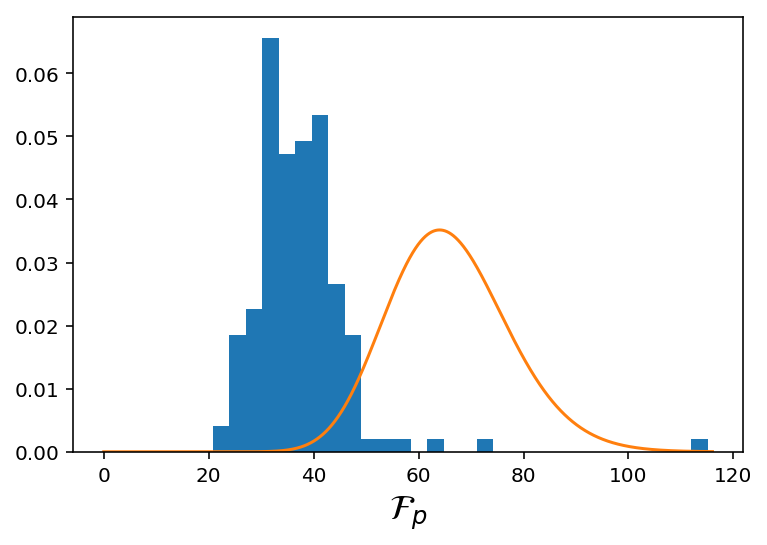

In [25]:
#Test Histograms
#Making chi squared values
dof_mdc2 = 2*len(psrs_mdc2)
N_x_mdc2 = 10000
chi_x_mdc2 = np.linspace(0,int(max(fstat_array_mdc2))+1,N_x_mdc2)

nbins = 30
#plt.hist(fstat_array,bins = nbins,density = True)
plt.hist(2*fstat_array_mdc2,bins = nbins,density = True)
plt.plot(chi_x_mdc2,chi2.pdf(chi_x_mdc2,dof_mdc2))
#plt.hist(fstat_array_test,bins = nbins,density = True)
plt.xlabel(r'$\mathcal{F}_{p}$',fontsize = 'xx-large')
plt.show()

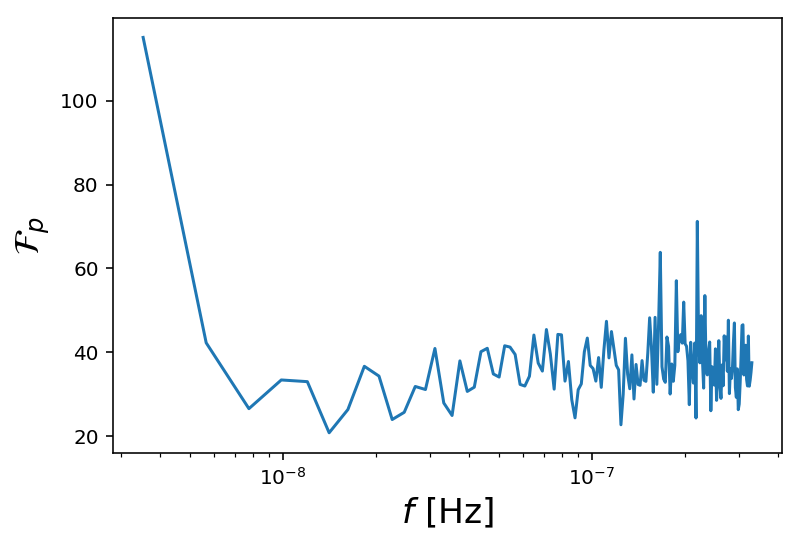

In [26]:
#Test Frequency plots
plt.plot(linfreqs_mdc2,fstat_array_mdc2)
plt.xscale('log')
plt.ylabel(r'$\mathcal{F}_{p}$',fontsize = 'xx-large')
plt.xlabel(r'$f$ [Hz]',fontsize = 'xx-large')
plt.show()

# Fe Statistic

In [27]:
def AndrewFestat2(psrs,Nmat,aligned_toas,f0,gwphi,gwtheta):
    '''Takes in the pulsars that make up the pta, the Nmatrix from GetNmat 
    (Should make this a function in ptas to use self instead of pta?),
    the frequency of the gravitational wave, phi (GW azimuthal angle in radians), 
    and theta (GW polar angle in radians).
    Returns the Fe statistic
    '''
    festat = 0.0
    
    #Probably a better way of doing this as well, but using TNTs[ii] for example didn't work
    for ii,p in enumerate(psrs):
        # define N vectors from Ellis et al, 2012 N_i=(x|A_i) for each pulsar
        N = np.zeros(4)
        # define M matrix M_ij=(A_i|A_j)
        M = np.zeros((4,4))

        fplus, fcross, cosMu = utils.create_gw_antenna_pattern(p.pos, gwtheta, gwphi)

        # define A
        A = np.zeros((4, len(aligned_toas[ii])))
        A[0,:] = fplus/f0**(1./3.) * np.sin(2*np.pi*f0*aligned_toas[ii])
        A[1,:] = fplus/f0**(1./3.) * np.cos(2*np.pi*f0*aligned_toas[ii])
        A[2,:] = fcross/f0**(1./3.) * np.sin(2*np.pi*f0*aligned_toas[ii])
        A[3,:] = fcross/f0**(1./3.) * np.cos(2*np.pi*f0*aligned_toas[ii])

        N += np.array([np.dot(A[0,:], np.dot(Nmat[ii],p.residuals)), \
                    np.dot(A[1,:], np.dot(Nmat[ii],p.residuals)), \
                    np.dot(A[2,:], np.dot(Nmat[ii],p.residuals)), \
                    np.dot(A[3,:], np.dot(Nmat[ii],p.residuals))])
    
        # define M matrix M_ij=(A_i|A_j)
        M += np.dot(A, np.dot(Nmat[ii], A.T))
        
        
        # take inverse of M
        Minv = sl.pinv(M)
        
        festat += 0.5 * np.dot(N, np.dot(Minv, N))
        
    return festat

In [28]:
#Pick gw sky location for tests
gwtheta = 30/180*np.pi
gwphi = 10/180*np.pi

In [34]:
i = 1
festat_array_mdc2 = []
start = time.time()
for gwfreq in linfreqs_mdc2:
    festat_array_mdc2.append(AndrewFestat2(psrs_mdc2,Nmat_mdc2,newtoas_mdc2,gwfreq,gwtheta,gwphi))
    if i % 10 == 0:
        end = time.time()
        print(repr(i) + ' Done. ' + ' Time Elapsed: ' + repr(end-start))
    i += 1

10 Done.  Time Elapsed: 0.11517810821533203
20 Done.  Time Elapsed: 0.19217896461486816
30 Done.  Time Elapsed: 0.27945923805236816
40 Done.  Time Elapsed: 0.36846256256103516
50 Done.  Time Elapsed: 0.4592912197113037
60 Done.  Time Elapsed: 0.5357635021209717
70 Done.  Time Elapsed: 0.6189053058624268
80 Done.  Time Elapsed: 0.6943676471710205
90 Done.  Time Elapsed: 0.7687180042266846
100 Done.  Time Elapsed: 0.8466770648956299
110 Done.  Time Elapsed: 0.9356486797332764
120 Done.  Time Elapsed: 1.009437084197998
130 Done.  Time Elapsed: 1.0938000679016113
140 Done.  Time Elapsed: 1.1952283382415771
150 Done.  Time Elapsed: 1.2711572647094727


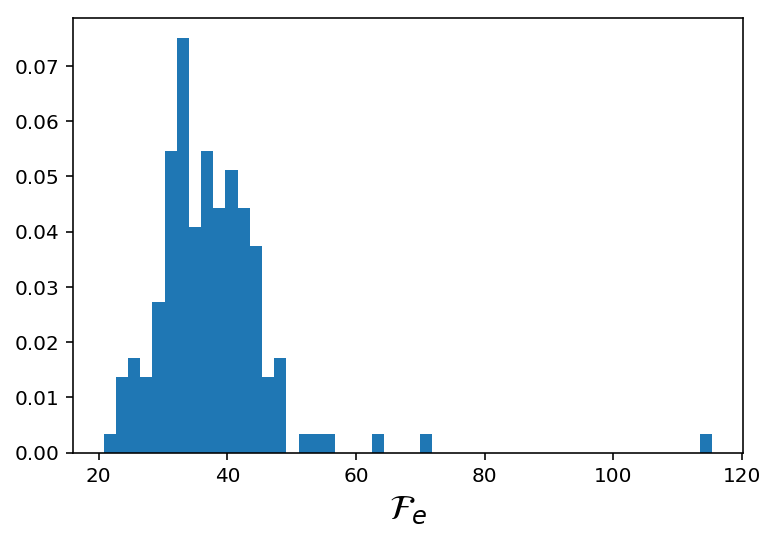

In [35]:
nbins = 50
plt.hist(festat_array_mdc2,bins = nbins,density = True)
plt.xlabel(r'$\mathcal{F}_{e}$',fontsize = 'xx-large')
plt.show()